# NN (L) Global Sustainable Equity time series forecasting using Prophet

## Start timing the analysis

In [1]:
import timeit
start_time = timeit.default_timer()

## Import all the necessary libraries

In [2]:
# Import all the necessary libraries
import time
import os
import datetime as dt
import pandas as pd
import io
import matplotlib.pyplot as plt

from fbprophet import Prophet
import itertools
import numpy as np
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import warnings
from dask.distributed import Client # import Dask for parallelising cross validation

## Import, clean and visualise the historical data

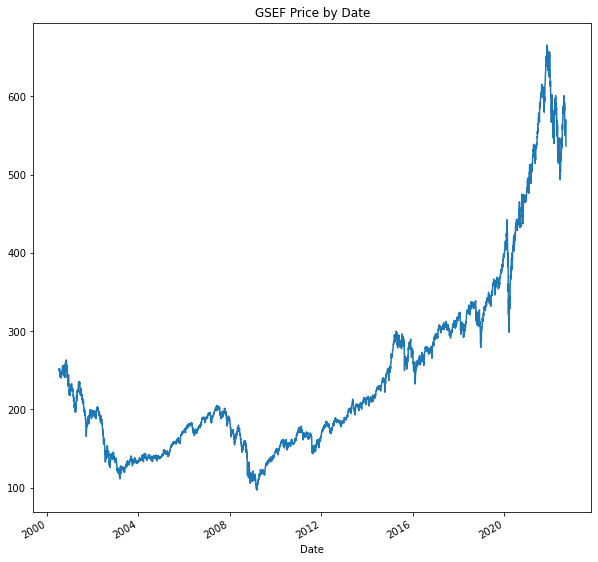

In [3]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_column',None)
tomorrow = (dt.date.today() + dt.timedelta(days=1)).isoformat() #get tomorrow in iso format as needed'''
url = pd.read_html("https://markets.ft.com/data/funds/tearsheet/historical?s=LU0119216553:EUR", header=0)
table = url[0]
gsef_latest = table[['Date', 'Close']]
gsef_latest_selected= gsef_latest.copy()

gsef_latest_selected['Date'] = gsef_latest_selected.loc[:,'Date'].str[-12:]
gsef_latest_selected['Date'] = pd.to_datetime(gsef_latest_selected['Date'], dayfirst=True)

gsef_historical= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], dayfirst=True)

gsef = pd.concat([gsef_latest_selected, gsef_historical], ignore_index=True).sort_values(by="Date")

gsef = gsef.reset_index(drop=True)

gsef['pct_change']= (gsef["Close"].pct_change()*100).round(2)

gsef = gsef.drop_duplicates('Date')

gsef.to_csv('gsef_output/historical_gsef.csv', index=False)

gsef.plot(x= 'Date', y='Close', figsize=(10,10), title= 'GSEF Price by Date', legend=False)

historical_chart= 'gsef_output/gsef_historical.png'

# Check if the historical data's chart exists and save its latest version
if os.path.exists(historical_chart):
  os.remove(historical_chart)
else:
  print("The historical chart didn't exist and it has been created.")

plt.savefig('gsef_output/gsef_historical.png')

plt.show()

In [4]:
# Brief Description of our dataset
gsef.describe()

Close   pct_change
count  5600.00000  5599.000000
mean    242.39478     0.019687
std     121.35619     1.087139
min      96.81000    -9.930000
25%     157.62750    -0.480000
50%     196.15000     0.070000
75%     294.77000     0.555000
max     665.45000     9.540000

In [5]:
gsef.info() # Check whether the date is as object type or date type

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5600 entries, 0 to 5606
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5600 non-null   datetime64[ns]
 1   Close       5600 non-null   float64       
 2   pct_change  5599 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 175.0 KB


In [6]:
gsef.tail()

Date   Close  pct_change
5602 2022-09-12  569.93        0.54
5603 2022-09-13  553.18       -2.94
5604 2022-09-14  552.05       -0.20
5605 2022-09-15  545.06       -1.27
5606 2022-09-16  536.52       -1.57

In [7]:
# Drop the columns
gsef = gsef.drop('pct_change', axis=1)
gsef.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

gsef.tail()

ds       y
5602 2022-09-12  569.93
5603 2022-09-13  553.18
5604 2022-09-14  552.05
5605 2022-09-15  545.06
5606 2022-09-16  536.52

## Hyperparameter tuning

In [8]:
client = Client()  # connect to the cluster

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
#     'daily_seasonality': [False]
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(gsef)  # Fit model with given params
#     df_cv = cross_validation(m, horizon='30 days', parallel="dask")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)

In [9]:
# best_params = all_params[np.argmin(rmses)]
# print(best_params)

In [10]:
# changepoint_prior_scale= best_params['changepoint_prior_scale'] # last selected changepoint_prior_scale= 0.5
# seasonality_prior_scale= best_params['seasonality_prior_scale'] # last selected seasonality_prior_scale= 0.01

## Initiating and training the Prophet algorithm

Steps for using Prophet:
- Make sure you replace closing price for y and date for ds.
- Fit that dataframe to Prophet in order to detect future patterns.
- Predict the upper and lower prices of the closing price.

In [11]:
#m = Prophet(daily_seasonality=False, changepoint_prior_scale= changepoint_prior_scale, seasonality_prior_scale= seasonality_prior_scale)

#m = Prophet(daily_seasonality=False, weekly_seasonality=False)

m = Prophet(daily_seasonality=False)

m.fit(gsef)

In [12]:
# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
5960 2023-09-12  684.408256  654.417315  717.202470
5961 2023-09-13  684.689093  654.734671  717.266780
5962 2023-09-14  684.757966  653.082257  717.396464
5963 2023-09-15  684.851773  653.825445  719.797790
5964 2023-09-16  680.798206  649.616208  714.312266

You can plot the forecast by calling the Prophet.plot method and passing in your forecast dataframe.

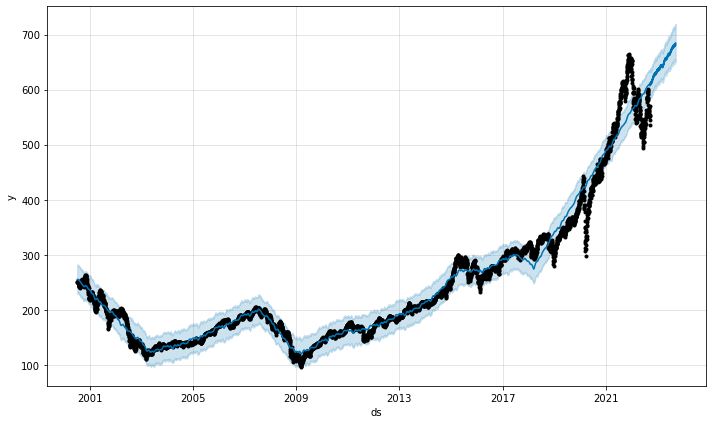

In [13]:
fig1 = m.plot(forecast)

## Plot the trend and the yearly seasonality

If you want to see the forecast components, you can use the Prophet.plot_components method. By default you’ll see the trend, yearly seasonality, and weekly seasonality of the time series. If you include holidays, you’ll see those here, too.

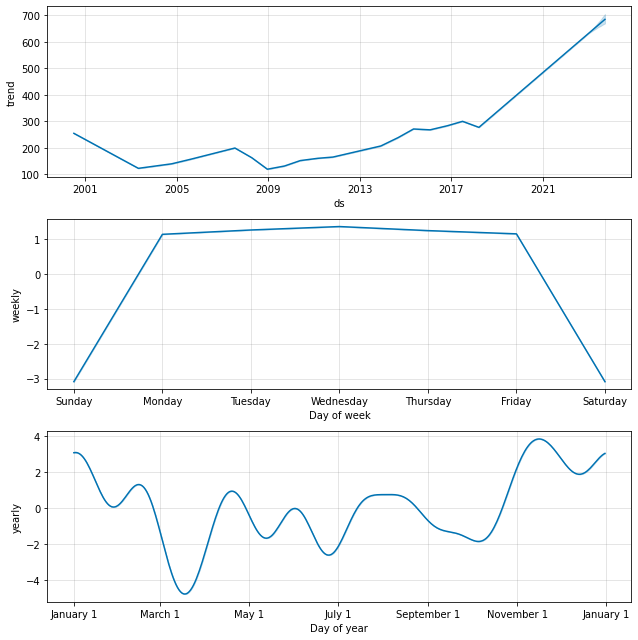

In [14]:
fig2 = m.plot_components(forecast)

An interactive figure of the forecast and components can be created with plotly. You will need to install plotly 4.0 or above separately, as it will not by default be installed with prophet. You will also need to install the notebook and ipywidgets packages.

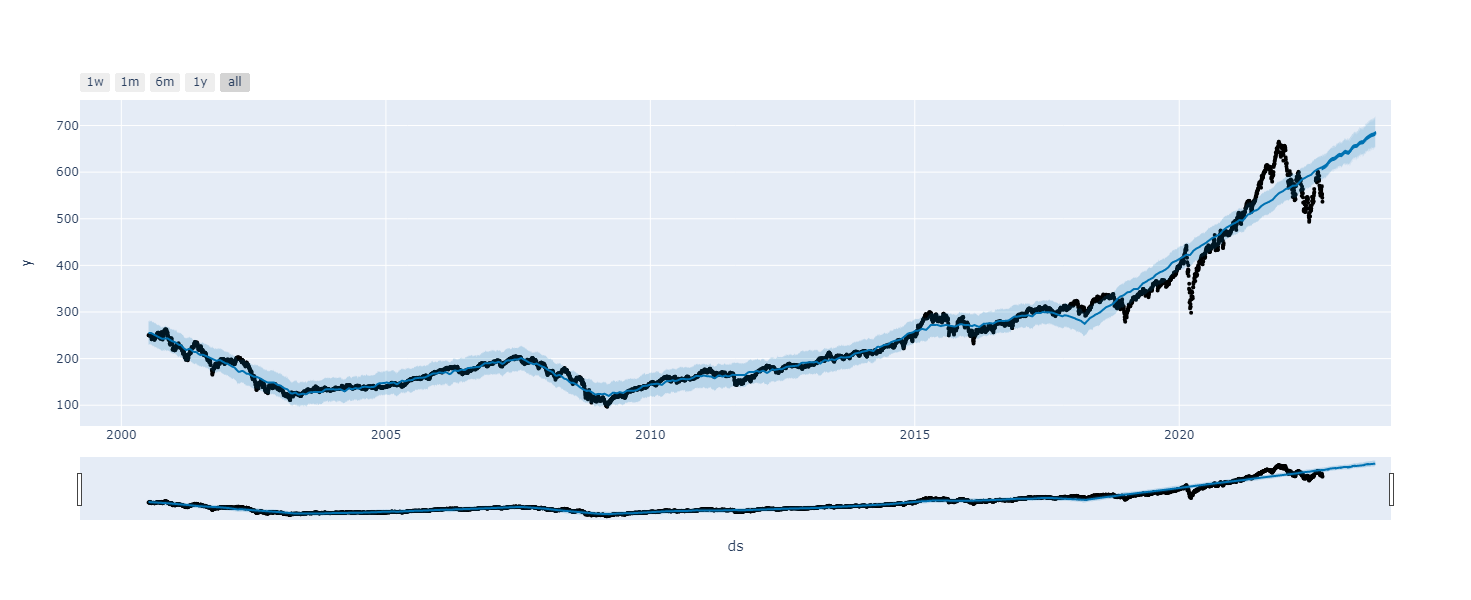

In [15]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

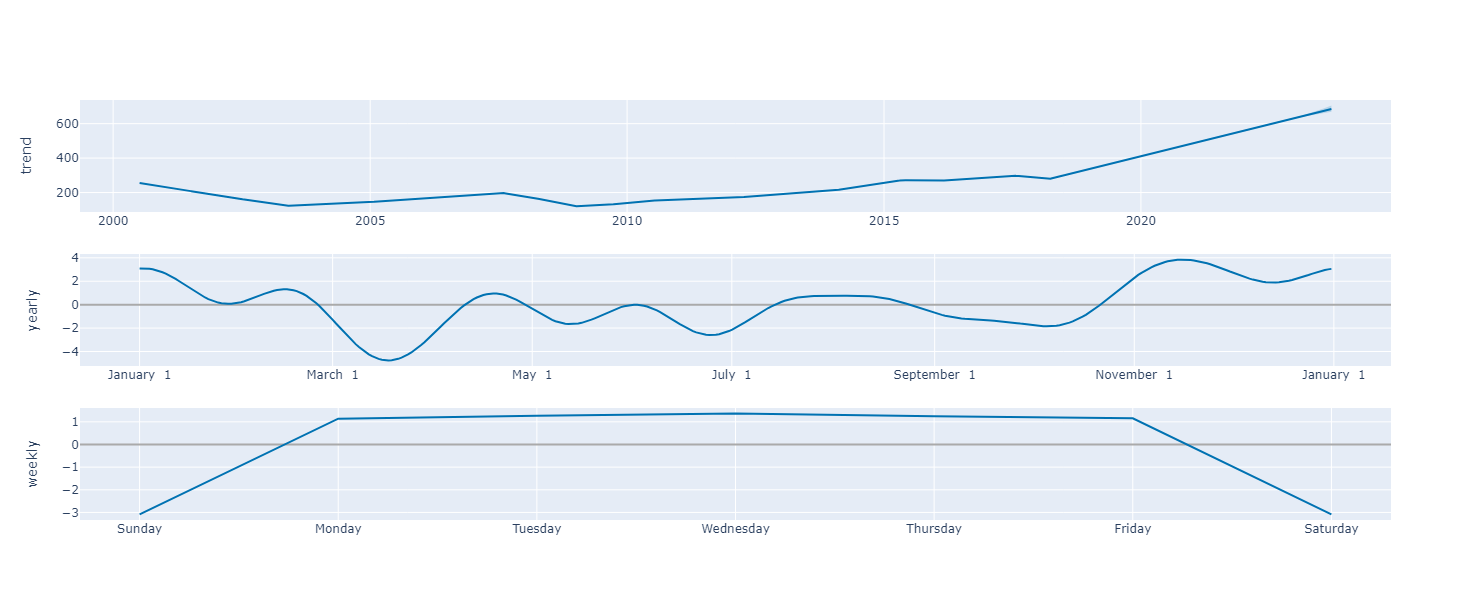

In [16]:
plot_components_plotly(m, forecast)

## Parallelized Cross validation

In [17]:
df_cv = cross_validation(m, horizon='30 days', parallel="dask")

INFO:prophet:Making 515 forecasts with cutoffs between 2001-07-08 00:00:00 and 2022-08-17 00:00:00
INFO:prophet:Applying in parallel with <Client: 'tcp://127.0.0.1:56904' processes=4 threads=8, memory=15.39 GiB>
2022-09-17 10:28:06,140 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:56946', name: 1, status: running, memory: 14, processing: 116>
2022-09-17 10:28:25,645 - distributed.nanny - WARNING - Worker process still alive after 3.9999975204467777 seconds, killing
2022-09-17 11:33:06,046 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:56940', name: 3, status: running, memory: 212, processing: 16>
2022-09-17 11:33:25,297 - distributed.nanny - WARNING - Worker process still alive after 3.9999946594238285 seconds, killing


In [18]:
df_cv.tail()

ds        yhat  yhat_lower  yhat_upper       y     cutoff
10660 2022-09-12  614.497081  589.897051  638.983184  569.93 2022-08-17
10661 2022-09-13  614.738399  589.123554  638.826193  553.18 2022-08-17
10662 2022-09-14  614.905335  589.664130  639.954495  552.05 2022-08-17
10663 2022-09-15  614.847050  589.450734  641.186270  545.06 2022-08-17
10664 2022-09-16  614.833481  588.190066  639.147709  536.52 2022-08-17

In [19]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse        mae      mape     mdape     smape  \
0  3 days  659.003136  25.671056  15.809865  0.060979  0.041429  0.062246   
1  4 days  695.128261  26.365285  16.210699  0.062289  0.042166  0.063568   
2  5 days  714.766246  26.735113  16.482703  0.063644  0.043324  0.064997   
3  6 days  715.262813  26.744398  16.662189  0.064502  0.044287  0.065911   
4  7 days  697.493977  26.410111  16.545409  0.064820  0.044029  0.066202   

   coverage  
0  0.506952  
1  0.491562  
2  0.479362  
3  0.466261  
4  0.469950

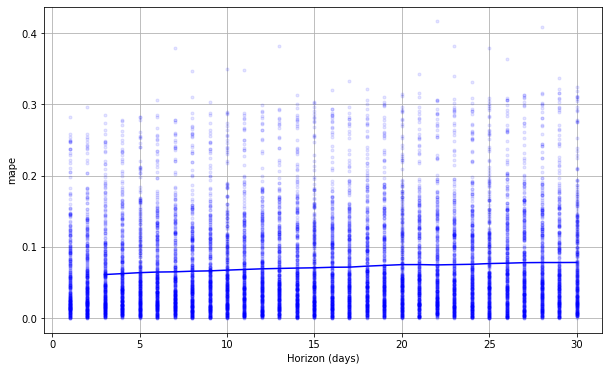

In [20]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

## Calculate the analysis' and forecast's timing

In [21]:
# Calculate and print the time elapsed to run ETL process and the date and time of the latest run
time_elapsed = timeit.default_timer() - start_time

time_elapsed_minutes = int((time_elapsed % 3600) // 60)

time_elapsed_seconds = int(time_elapsed % 60)

now = dt.datetime.now()

print("\n Success! Your GSEF forecast using Prophet has been updated in {} minutes and {} seconds on {}".format(time_elapsed_minutes, time_elapsed_seconds, now.strftime("%Y-%m-%d %H:%M:%S")))


 Success! Your GSEF forecast using Prophet has been updated in 47 minutes and 12 seconds on 2022-09-17 12:00:13


## Possible improvements of this analysis

1) Can more hyperparameter tuning be implemented to significantly improve accuracy?
2) If necessary, re-order the analysis in the notebook and automate the analysis wherever possible
3) Remove any unnecessary or steps that don't add value from the analysis 
4) Document the notebook 
5) Create a .py script of the notebook 